# Introduction

## Goal

The objective of this project is to calibrate an air pollution sensor in an air pollution monitoring sensor network. We will take the data sampled of one node that accommodates three sensors: a MIC2614 $O_3$ sensor, a temperature sensor and a relative humidity sensor.

In [1]:
# Uncomment to install packages
# !pip3 install numpy --user --upgrade --quiet
# !pip3 install pandas --user --upgrade --quiet
# !pip3 install scipy --user --upgrade --quiet
# !pip3 install statsmodels --user --upgrade --quiet
# !pip3 install seaborn --user --upgrade --quiet
# !pip3 install matplotlib --user --upgrade --quiet
# !pip3 install scikit-learn --user --upgrade --quiet

%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
import scipy

from time import time, sleep
from datetime import timedelta
import json

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, \
  mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
 
# Colors & Style
sns.set_style('whitegrid')
colormap = sns.color_palette("Blues", as_cmap=True)

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

random_seed = 42

print('Pandas', pd.__version__)
print('Seaborn', sns.__version__)
print('Scikit-learn', sklearn.__version__)

Pandas 1.2.4
Seaborn 0.11.1
Scikit-learn 0.24.2


## The dataset

In [3]:
df = pd.read_csv('data.csv', sep=';')

In [4]:
df.head()

,date,RefSt,Sensor_O3,Temp,RelHum
0,21/06/2017 7:00,15.0,36.3637,21.77,53.97
1,21/06/2017 7:30,15.0,34.8593,25.50,42.43
2,21/06/2017 8:00,19.0,37.3510,27.97,34.93
3,21/06/2017 8:30,26.0,43.6993,29.41,32.07
4,21/06/2017 9:00,34.0,53.9600,30.20,30.83


In [5]:
print(f'Columns: {df.shape[1]}\nRows: {df.shape[0]}')
print('Columns types:')
print(df.dtypes)

Columns: 5
Rows: 1000
Columns types:
date          object
RefSt        float64
Sensor_O3    float64
Temp         float64
RelHum       float64
dtype: object


The dataset has $1000$ samples and $5$ columns:

- Date: *UTC*
- Temperature: °$C$ ($\mathbb{R}$)
- Humidity: $\%$ ($\mathbb{R}$)
- $O_3$: $K\Omega$ ($\mathbb{R}$)
- True $O_3$: $\mu gr/m^3$ ($\mathbb{R}$)

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df['date'][:5]

0   2017-01-07 00:00:00
1   2017-01-07 00:30:00
2   2017-01-07 01:00:00
3   2017-01-07 01:30:00
4   2017-01-07 02:00:00
Name: date, dtype: datetime64[ns]

In [7]:
new_columns = {
    'date': 'date',
    'RefSt': 'real_ozone',
    'Sensor_O3': 'ozone',
    'Temp': 'temperature',
    'RelHum': 'humidity'
}
df.rename(columns=new_columns, inplace=True)
new_order = ['date', 'temperature', 'humidity', 'ozone', 'real_ozone']
df = df.reindex(columns=new_order)
df.columns

Index(['date', 'temperature', 'humidity', 'ozone', 'real_ozone'], dtype='object')

In [8]:
df.describe().loc[['mean','std']]

,temperature,humidity,ozone,real_ozone
mean,24.966410,42.018640,234.839993,64.477000
std,6.443502,14.877965,172.064966,41.950129


Before we start with the exploration data analysis (EDA) we need to clean our dataset and deal with the missing values.

In [9]:
def displayMissingValues():
    plt.title('Missing values',fontsize=12, y=-0.2)
    ax = sns.heatmap(
        pd.DataFrame(df.isna().sum()),
        annot=True, 
        fmt='d', 
        vmin=0, 
        vmax=df.shape[0], 
        cmap=colormap,
        yticklabels=['temp.','humidity','ozone','true ozone']
    )

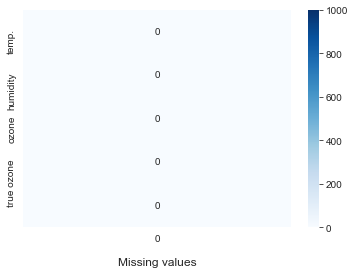

In [10]:
displayMissingValues()

Lucky, the dataset has already been preprocessed in terms of missing values so we can jump into EDA.

# Part I: Exploratory Data Analysis

Exploratory data analysis (EDA) is used by data scientists to analyze and investigate data sets and summarize their main characteristics, often employing data visualization methods. It helps determine how best to manipulate data sources to get the answers you need, making it easier for data scientists to discover patterns, spot anomalies, test a hypothesis, or check assumptions.

In [11]:
colorDict = {
    'temperature': 'lightcoral',
    'humidity': 'cornflowerblue',
    'ozone': 'limegreen',
    'real_ozone': 'gold',
}

palette = sns.color_palette(list(colorDict.values()))

First, we are going to use a *pair plot*. A pairs plot allows us to see both distribution of single variables and relationships between two variables. Pair plots are a great method to identify trends for follow-up analysis.

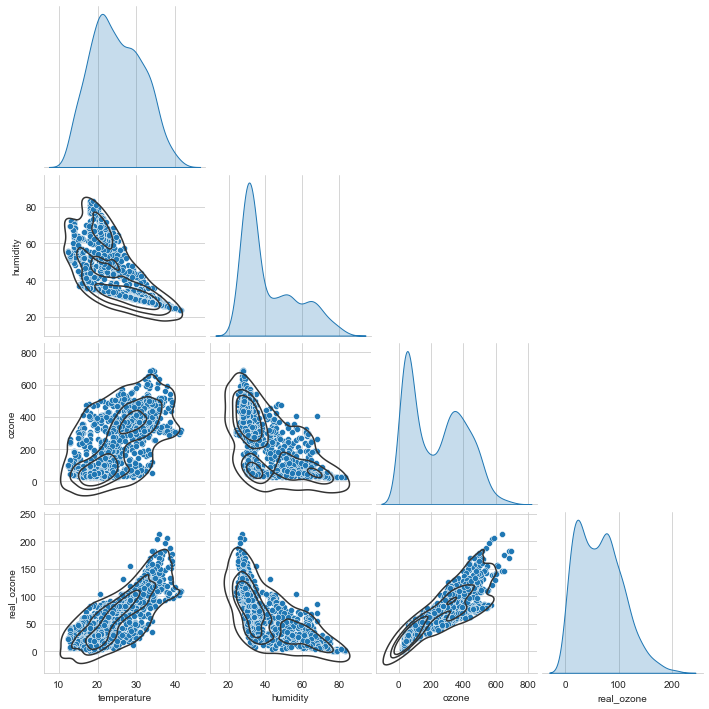

In [17]:
g = sns.pairplot(df, diag_kind='kde', palette=palette, corner=True)
_ = g.map_lower(sns.kdeplot, levels=4, color=".2")

Then, we are going to use a *box plot* to visualize each different feature and its range. The box plot allow us to easily visualize the standard deviation and the outliers of our data.

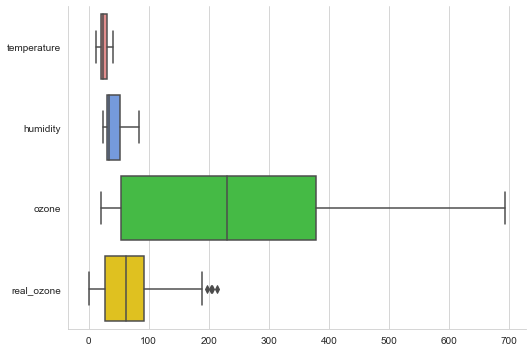

In [18]:
_ = sns.catplot(data=df, 
            kind='box', 
            orient='h', 
            height=5, 
            aspect=1.5, 
            palette=palette)

We can observe in the box plot that the data is clearly not *normalized* so we will scale it during the preprocessing.

We also see that $O_3$ and $O_3$(true) have some *outliers*.

Let's have a look at the distribution of each feature using a *histogram* and the *kernel density estimation*.

In [19]:
font = {'size': 14, 'weight': 'bold'}

def plot_hist_box(df, col, color):
    fig, axs= plt.subplots(1,2, gridspec_kw = {'width_ratios': [4, 1]}, figsize = (9,4), sharey=False)
    axs[0].set_xlabel(axs[0].get_xlabel(),fontdict=font)
    axs[0].set_title('Histogram with KDE')
    axs[1].set_title('Boxplot')
    hist = sns.histplot(data=df, x=col, kde=True, element='step', fill=True, ax=axs[0], color=color)
    _ = sns.boxplot(data=df, y=col, ax=axs[1], color=color)

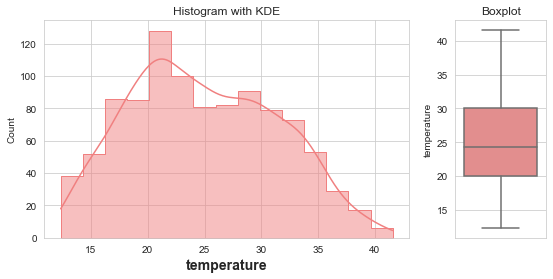

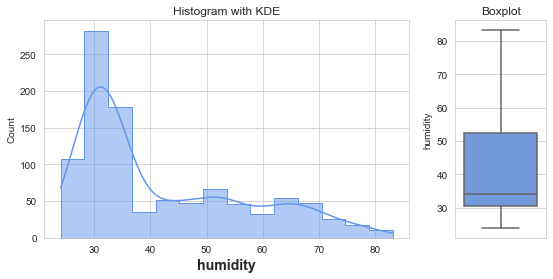

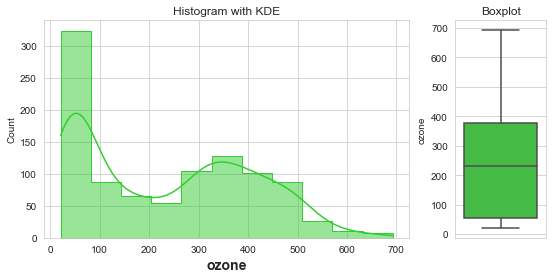

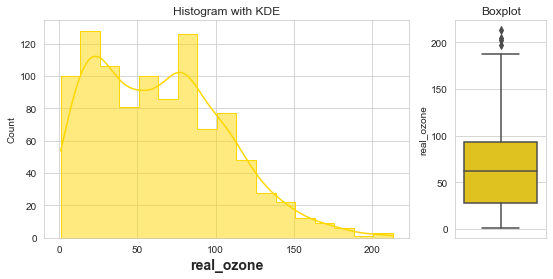

In [20]:
for col in df.columns:
    if col == 'date':
        continue
    color = colorDict[col]
    plot_hist_box(df, col, color=color)

All three humidity, $O_3$, and $O_3$(true) are *skewed*. We will need to take this into consideration during the modeling since some of our models will assume that each feature follows a *normal distribution*.

Next, we are going to have a look at the relation between the variables.

The scale of *ozone* and *true ozone* are different. The ozone sensor works as a voltage divisor which is represented as a variable resistor ($k\Omega)$ while the reference $O_3$ is measured in $\mu gr/m^3$.

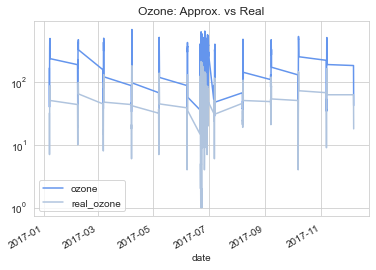

In [12]:
axs= df.plot(
    x='date', 
    y=['ozone', 'real_ozone'],
    kind='line', 
    logy=True,
    color=['cornflowerblue','lightsteelblue'],
    title='Ozone: Approx. vs Real',
)

Despite being in different scales, clearly both variables follow the same pattern.

In [13]:
def standarize(df, columns):
    scaler = StandardScaler()
    r = df.copy()
    r[columns] = scaler.fit_transform(df[columns])
    return r

def scatter_plot(df, x, y, title, color, ax=None):
    _ = df.plot(
        x=x, 
        y=y,
        kind='scatter',
        title=title,
        color=color,
        xlabel='Approx. $O_3$',
        ylabel='True $O_3$',
        ax=ax,
        s=5,
    )
    return None

If the MIC2614 $O_3$ sensor was as good as the reference station, we could use it directly with no calibration. But, as we will see in the next plot, the MIC2614 $O_3$ is not enough to predict the real $O_3$: a perfect prediction would lie in the diagonal of the plot which is not the case.

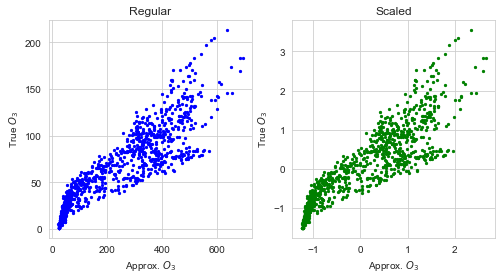

In [14]:
fig, axs = plt.subplots(1,2, figsize = (8,4))
scatter_plot(df, x='ozone', y='real_ozone', title='Regular', color='blue', ax=axs[0])
df_scaled = standarize(df, columns = ['ozone', 'real_ozone'])
scatter_plot(df_scaled, x='ozone', y='real_ozone', title='Scaled', color='green', ax=axs[1])    

Also, the *standarization* does not change the pattern.

Now, we plot the temperature and the humidity against the $O_3$ to see if there any pattern.

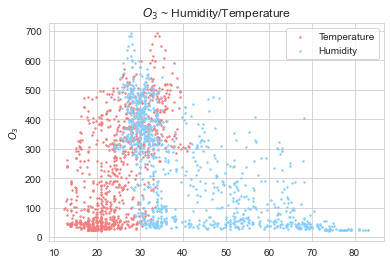

In [15]:
def scatter_plot(df, x, y, label, color, ax=None):
    ax = df.plot(
        x=x, 
        y=y,
        kind='scatter',
        title='$O_3$ ~ Humidity/Temperature',
        color=color,
        xlabel='',
        ylabel='$O_3$',
        ax=ax,
        label=label,
        legend=True,
        s=2,
    )
    return ax

ax = scatter_plot(df, x='temperature', y='ozone', label='Temperature', color='lightcoral')
_ = scatter_plot(df, ax=ax, x='humidity', y='ozone', label='Humidity', color='lightskyblue')    

The relation between those variables is the following:

- The higher the temperature, the higher the $O_3$.
- The lower the humidity, the higher the $O_3$.

Let's try to plot the same variables against the reference $O_3$.

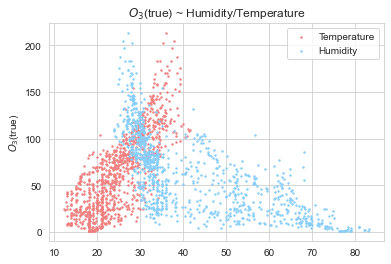

In [16]:
def scatter_plot(df, x, y, label, color, ax=None):
    ax = df.plot(
        x=x, 
        y=y,
        kind='scatter',
        title='$O_3$(true) ~ Humidity/Temperature',
        color=color,
        xlabel='',
        ylabel='$O_3$(true)',
        ax=ax,
        label=label,
        legend=True,
        s=2,
    )
    return ax

ax = scatter_plot(df, x='temperature', y='real_ozone', label='Temperature', color='lightcoral')
_ = scatter_plot(df, ax=ax, x='humidity', y='real_ozone', label='Humidity', color='lightskyblue')    

These relations are clear on the correlation plot that we will see next.

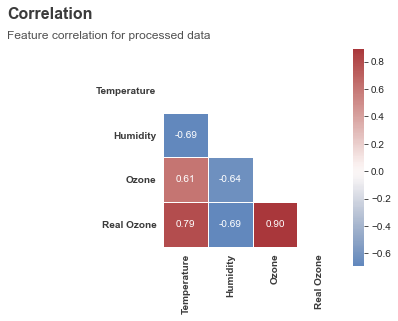

In [21]:
cmap = sns.color_palette("vlag", as_cmap=True)

corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (4,4))
sns.heatmap(corr, ax=ax, fmt='.2f', cmap=cmap, annot=True,
            center=0, mask=mask, linewidths=.5, square=True)
ax.text(-3.5,-1.1, 'Correlation',{'size': 16, 'weight':'bold'}, alpha = 0.9)
ax.text(-3.5,-0.65, 'Feature correlation for processed data',{'size': 12, 'weight':'normal'}, alpha = 0.8)
ax.tick_params(axis = 'y', rotation=0)
xticks = ['Temperature', 'Humidity', 'Ozone','Real Ozone']
yticks = ['Temperature', 'Humidity', 'Ozone','Real Ozone']
ax.set_xticklabels(xticks, {'size':10, 'weight':'bold'},rotation = 90, alpha = 0.9)
ax.set_yticklabels(yticks, {'size':10, 'weight':'bold'}, rotation = 0, alpha = 0.9)

fig.show()

- There is high correlation between temperature and $O_3$.
- There is high negative correlation between humidity and $O_3$.
- There is very high correlation between $O_3$ and reference $O_3$.

# Part II: Calibration

Drop *date*: we will consider that the samples are independent to simplify the analysis.

In [22]:
df = df.drop(['date'], axis=1)

### Outliers

Real ozone seems to have some *outliers* (see Real Ozone boxplot).

(789, 4)


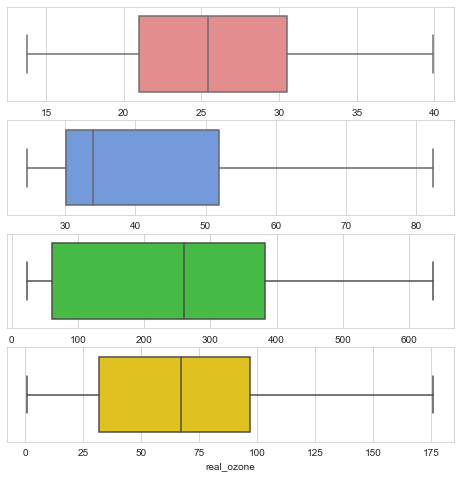

In [23]:
df_aux = df.copy()

for col in df.columns:
    lof = LocalOutlierFactor(n_neighbors=20, n_jobs=-1)
    result = lof.fit_predict(df_aux[col].values.reshape(-1, 1))
    df_aux = df_aux[result == 1]
print(df_aux.shape)

fig, axs = plt.subplots(4, figsize=(8,8), sharey=False)
for i, col in enumerate(df_aux.columns):
    _ = sns.boxplot(data=df_aux, x=col, ax=axs[i], color=colorDict[col])

We decided **not to filter out** the possible outliers since *Local Outlier Factor* is removing ~200 samples which is a 20% of the total.

### Normalization

The features 'humidity', 'ozone', and 'real ozone' are *skewed* as we saw in the histograms from the previous section. 

We can avoid this that applying a *logarithm* to this column, as all values are positive.

In [24]:
def plot_hist_log(df, col, color):
    fig, axs= plt.subplots(1,2, gridspec_kw = {'width_ratios': [2, 2]}, figsize = (9,4), sharey=False)
    axs[0].set_title('')
    axs[1].set_title('$\log_{10}$')
    hist = sns.histplot(data=df, x=col, kde=True, element='step', fill=True, ax=axs[0], color=color)
    hist = sns.histplot(log_scale=True,data=df, x=col, kde=True, element='step', fill=True, ax=axs[1], color=color)

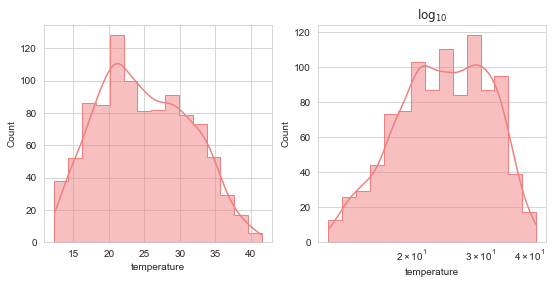

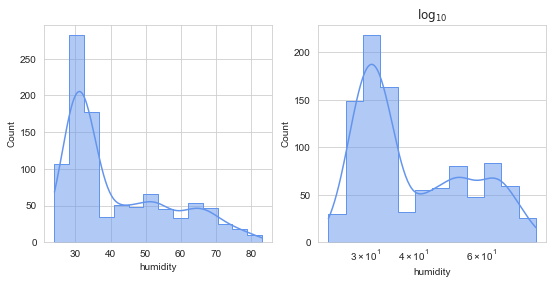

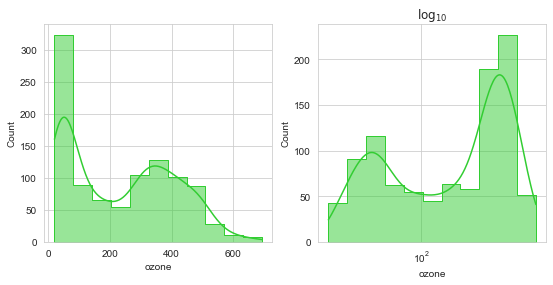

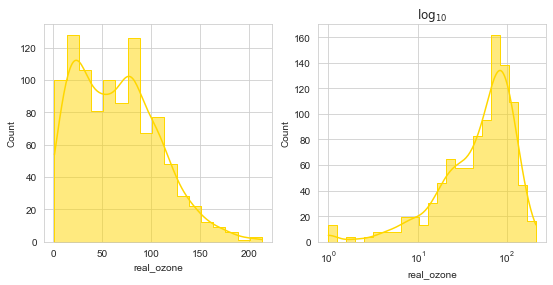

In [25]:
for col in df.columns:
    color = colorDict[col]
    plot_hist_log(df, col, color=color)

Changing the scale on 'temperature' and 'real ozone' seems to have worked but 'humidity' and 'ozone' still have this multivariate normal distribution shape.

### Factor analysis

Factor analysis in this dataset is not worth exploring since the number of variables is already really small.

## Modeling

Pick the best model and hyperparameters.

### Preprocessing and Resampling

We use a RobustScaler since the StandardScaler does not work well in the presence of outliers (see [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)).

In [26]:
def preprocessing(X, y):
    lof = LocalOutlierFactor(n_neighbors=20, n_jobs=-1)
    result = lof.fit_predict(X)
    X = X[result == 1]
    y = y[result == 1]
    
    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    
    return X, y

def preprocessing_test(X, y):
    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    return X, y

In [27]:
X = df.loc[:, df.columns != 'real_ozone']
y = df['real_ozone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_seed)

X_train, y_train = preprocessing(X_train, y_train)
X_val, y_val = preprocessing_test(X_val, y_val)
X_test, y_test = preprocessing_test(X_test, y_test)

print('Train: ', X_train.shape)
print('Validation: ', X_val.shape)
print('Test: ', X_test.shape)

Train:  (580, 3)
Validation:  (200, 3)
Test:  (200, 3)


### Metrics

We are going to use the following regression metrics:

$$
MAE(y, \hat{y}) = \frac{1}{n}\sum_{i=0}^{n-1} |y_i - \hat{y_i}|
$$

$$
RMSE(y, \hat{y}) = \sqrt{\frac{1}{n}\sum_{i=0}^{n-1} (y_i - \hat{y_i})^2}
$$

$$
R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y_i})^2}{\sum_{i=1}^{n} (y_i - \bar{y_i})^2}
$$

In [28]:
metrics = ['MAE', 'RMSE', '$R^2$']
results = pd.DataFrame(columns=metrics)

In [29]:
def plot_results():
    display(results.sort_values(by='MAE',ascending=True))

In [30]:
def compute_metrics(y_true,y_pred):
    """Returns an array with all the metrics."""
    mae = mean_absolute_error(y_true,y_pred)
    rmse = mean_squared_error(y_true,y_pred, squared=False)
    r2 = r2_score(y_true,y_pred)
    return [mae,
            rmse,
            r2,
           ]

def evaluate(name, model, print_results=True):
    """Evaluates the model with the validation dataset."""
    try:
        model = model.best_estimator_
    except Exception as e:
        pass
    y_pred = model.predict(X_val)
    results.loc[name,:] = compute_metrics(y_val, y_pred)
    if print_results:
        plot_results()

### Model Selection

We are going to explore the following models:
- Linear Regression
- k-Nearest Neighbors Regression
- Random Forest Regression
- Kernel Regression
- Gaussian Process
- Support Vector Regression
- Neural Networks

First, we will evaluate the models with *default parameters*. Then, we are going to carefully tune the *hyperparameters* to get the best score out of them.

In [31]:
lr = LinearRegression(normalize=False)
ridge = Ridge(normalize=False, random_state=random_seed)
sgd = SGDRegressor(random_state=random_seed)
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state=random_seed)
krr = KernelRidge()
gp = GaussianProcessRegressor(random_state=random_seed)
svr = SVR()
nn = MLPRegressor(random_state=random_seed)

models = {
    'LR(default)': lr,
    'Ridge(default)': ridge,
    'LR-SGD(default)': sgd,
    'KNN(default)': knn,
    'RF(default)': rf,
    'KRR(default)': krr,
    'GP(default)': gp,
    'SVR(default)': svr,
    'NN(default)': nn,
}

In [32]:
for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate(name, model, print_results=False)
    
plot_results()

,MAE,RMSE,$R^2$
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(default),10.43362,13.456077,0.896253
SVR(default),12.209157,17.7752,0.818962
NN(default),19.542292,23.670468,0.678964
GP(default),26.807484,139.389439,-10.132677
KRR(default),41.903928,48.805811,-0.364844


The best model with default parameters is the Random Forest followed by K-Nearest Neighbors.

#### Hypertunning

In [33]:
def print_time(start, end):
    duration = timedelta(seconds=end-start)
    days, seconds = duration.days, duration.seconds
    minutes = (seconds % 3600) // 60
    seconds = (seconds % 60)
    print(f'{minutes} minutes, {seconds} seconds')
    
def print_best_params(cvModel):
    stringified = json.dumps(cvModel.best_params_, sort_keys=False, indent=2)
    print(stringified)

In [34]:
def hypertune(estimator, param_grid, extra_scoring_cols, print_scores=True, cv=10):
    """Returns the model hypertunned."""
    scoring_cols = extra_scoring_cols + [
        'mean_test_mae', 
        'mean_test_mse', 
        'mean_test_r2'
    ]
    
    scoring_dict = {
        'mae': 'neg_mean_absolute_error',
        'mse': 'neg_mean_squared_error',
        'r2': 'r2',
    }

    start = time()
    
    cvModel = GridSearchCV(
        estimator=estimator,
        scoring=scoring_dict,
        param_grid=param_grid,
        refit='mae',
        cv=cv,
        n_jobs=-1,
        return_train_score=False
    )

    cvModel = cvModel.fit(X_train, y_train)
    
    print_time(start, time())
    
    scores = pd.DataFrame(cvModel.cv_results_) \
              .sort_values(by='mean_test_mae',ascending=False)[scoring_cols] \
              .head()
    
    if print_scores:
        print_best_params(cvModel)
        display(scores)
    
    return cvModel

#### Multiple Linear Regression

Before applying *linear regression* we should validate if our data follow the assumptions.

In [35]:
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             real_ozone   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1591.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          3.42e-278
Time:                        14:38:32   Log-Likelihood:                -2320.3
No. Observations:                 580   AIC:                             4649.
Df Residuals:                     576   BIC:                             4666.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.5272      0.725     84.815      0.000      60.102      62.952
x1            24.4242      1.228     19.894      0.000      22.013      26.836
x2            -1.1010      1.211     -0.909      0.364      -3.480       1.278
x3            48.5845      1.470     33.049      0.000      45.697      51.472
==============================================================================
Omnibus:                        4.035   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                4.839
Skew:                           0.031   Prob(JB):                       0.0890
Kurtosis:                       3.443   Cond. No.                         3.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

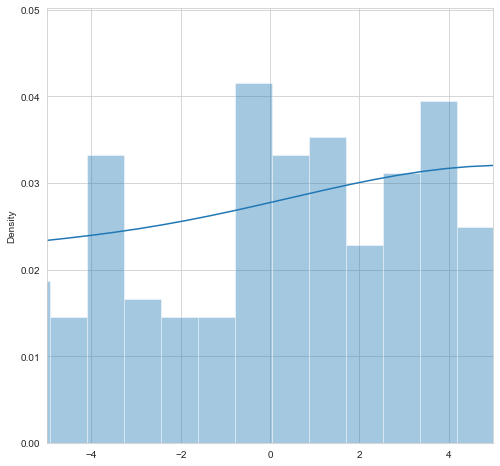

In [36]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-5,5])
sns.distplot(result.resid,bins=100);

We assume **normal distribution of error terms** in LR. 
The previous plot should look like a Gaussian distribution
in order to validate the assumption.

This is an indicator that LR may not perform the best.

We will also run a *QQ-plot* to validate our model.

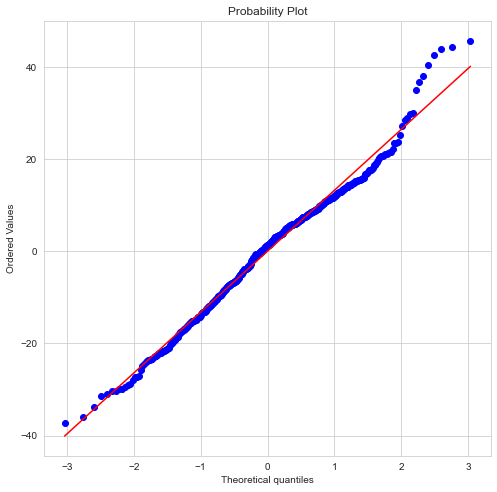

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
scipy.stats.probplot(result.resid, plot=plt);

The *QQ-plot* looks fine.

LinearRegression cannot be optimized since it has no hyperparameters.

In [38]:
alpha = [0.001,0.01,0.1,0.5,1,5,10,100]

param_grid={
    'alpha': alpha,
}

extra_scoring_cols = [
    'param_alpha',
]

ridge = Ridge(normalize=False, random_state=random_seed)
ridgeBest = hypertune(ridge, param_grid, extra_scoring_cols)
evaluate('Ridge(best)', ridgeBest)

0 minutes, 1 seconds
{
  "alpha": 1
}


,param_alpha,mean_test_mae,mean_test_mse,mean_test_r2
4,1,-10.552082,-177.208270,0.886404
3,0.5,-10.555654,-177.187459,0.886387
5,5,-10.558275,-178.206629,0.885999
2,0.1,-10.559142,-177.189949,0.886360
1,0.01,-10.559991,-177.192923,0.886352


,MAE,RMSE,$R^2$
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(default),10.43362,13.456077,0.896253
Ridge(best),10.43362,13.456077,0.896253
SVR(default),12.209157,17.7752,0.818962
NN(default),19.542292,23.670468,0.678964
GP(default),26.807484,139.389439,-10.132677
KRR(default),41.903928,48.805811,-0.364844


In [39]:
penalty = ['l1', 'l2','elasticnet']
alpha = [0.01,0.1,0.5,1,5]
learning_rate=['constant', 'optimal', 'invscaling']

param_grid={
    'penalty': penalty,
    'alpha': alpha,
    'learning_rate': learning_rate,
}

extra_scoring_cols = [
    'param_penalty',
    'param_alpha',
    'param_learning_rate'
]

sgd = SGDRegressor(random_state=random_seed)
sgdBest = hypertune(sgd, param_grid, extra_scoring_cols)
evaluate('LR-SGD(best)', sgdBest)

0 minutes, 0 seconds
{
  "alpha": 0.5,
  "learning_rate": "constant",
  "penalty": "l1"
}


,param_penalty,param_alpha,param_learning_rate,mean_test_mae,mean_test_mse,mean_test_r2
18,l1,0.5,constant,-10.506823,-179.356750,0.885268
24,l1,0.5,invscaling,-10.532848,-178.564109,0.885773
0,l1,0.01,constant,-10.534928,-178.088059,0.885824
2,elasticnet,0.01,constant,-10.535063,-178.856681,0.885618
9,l1,0.1,constant,-10.536924,-178.474832,0.885601


,MAE,RMSE,$R^2$
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(default),10.43362,13.456077,0.896253
Ridge(best),10.43362,13.456077,0.896253
LR-SGD(best),10.88055,14.037045,0.887101
SVR(default),12.209157,17.7752,0.818962
NN(default),19.542292,23.670468,0.678964
GP(default),26.807484,139.389439,-10.132677


### k-Nearest Neighbors

In [40]:
n_neighbors = [2,5,10,20,30]
weights=['uniform','distance']
p=[1,2] # Minkowski distance

param_grid={
    'n_neighbors': n_neighbors,
    'weights': weights,
    'p': p,
}

extra_scoring_cols = [
    'param_n_neighbors',
    'param_weights',
    'param_p',
]

knn = KNeighborsRegressor()
knnBest = hypertune(knn, param_grid, extra_scoring_cols)
evaluate('KNN(best)', knnBest)

0 minutes, 0 seconds
{
  "n_neighbors": 5,
  "p": 1,
  "weights": "distance"
}


,param_n_neighbors,param_weights,param_p,mean_test_mae,mean_test_mse,mean_test_r2
5,5,distance,1,-7.304946,-101.120084,0.935764
9,10,distance,1,-7.312238,-101.161897,0.935946
7,5,distance,2,-7.386537,-101.616961,0.935508
11,10,distance,2,-7.452998,-101.733656,0.935537
4,5,uniform,1,-7.586897,-106.575034,0.932272


,MAE,RMSE,$R^2$
KNN(best),7.214225,9.795668,0.94502
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(default),10.43362,13.456077,0.896253
Ridge(best),10.43362,13.456077,0.896253
LR-SGD(best),10.88055,14.037045,0.887101
SVR(default),12.209157,17.7752,0.818962
NN(default),19.542292,23.670468,0.678964


### Random Forest

In [41]:
n_estimators = [50,100]
criterion = ['mse', 'mae']
max_depth = [100,None]
min_samples_split = [2,4]
min_samples_leaf = [2,4]
max_features = ['auto','sqrt','log2']

param_grid={
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf, 
    'max_features': max_features,
}

extra_scoring_cols = [
    'param_n_estimators', 
    'param_criterion',  
    'param_max_depth', 
    'param_min_samples_leaf', 
    'param_min_samples_split',
    'param_max_features',
]

rf = RandomForestRegressor(random_state=random_seed, n_jobs=-1)
rfBest = hypertune(rf, param_grid, extra_scoring_cols)
evaluate('RF(best)', rfBest)

0 minutes, 24 seconds
{
  "criterion": "mse",
  "max_depth": 100,
  "max_features": "auto",
  "min_samples_leaf": 2,
  "min_samples_split": 2,
  "n_estimators": 100
}


,param_n_estimators,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_max_features,mean_test_mae,mean_test_mse,mean_test_r2
3,100,mse,100,2,4,auto,-6.576690,-88.698258,0.943348
1,100,mse,100,2,2,auto,-6.576690,-88.698258,0.943348
27,100,mse,None,2,4,auto,-6.576690,-88.698258,0.943348
25,100,mse,None,2,2,auto,-6.576690,-88.698258,0.943348
75,100,mae,None,2,4,auto,-6.600129,-88.530604,0.943766


,MAE,RMSE,$R^2$
KNN(best),7.214225,9.795668,0.94502
RF(best),7.4194,9.750344,0.945527
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(default),10.43362,13.456077,0.896253
Ridge(best),10.43362,13.456077,0.896253
LR-SGD(best),10.88055,14.037045,0.887101
SVR(default),12.209157,17.7752,0.818962


### Kernel Regression

In [42]:
alpha = [0.01,0.1,0.5,1,5]
kernel = ['linear','polynomial','rbf','sigmoid']

param_grid={
    'alpha': alpha,
    'kernel': kernel
}

extra_scoring_cols = [
    'param_alpha', 
    'param_kernel'
]

krr = KernelRidge()
krrBest = hypertune(krr, param_grid, extra_scoring_cols)
evaluate('KRR(best)', krrBest)

0 minutes, 1 seconds
{
  "alpha": 0.01,
  "kernel": "rbf"
}


,param_alpha,param_kernel,mean_test_mae,mean_test_mse,mean_test_r2
2,0.01,rbf,-7.000097,-86.913575,0.944467
1,0.01,polynomial,-7.279903,-92.560738,0.940868
5,0.1,polynomial,-7.327127,-93.483444,0.940317
6,0.1,rbf,-7.411616,-95.050420,0.939293
9,0.5,polynomial,-7.515655,-97.363386,0.937898


,MAE,RMSE,$R^2$
KRR(best),6.749738,9.072946,0.952833
KNN(best),7.214225,9.795668,0.94502
RF(best),7.4194,9.750344,0.945527
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(default),10.43362,13.456077,0.896253
Ridge(best),10.43362,13.456077,0.896253
LR-SGD(best),10.88055,14.037045,0.887101


### Gaussian Process

In [43]:
from sklearn.gaussian_process.kernels import DotProduct, RBF

kernel = [DotProduct(), RBF()]
param_grid={
    'kernel': kernel,
}

extra_scoring_cols = [
    'param_kernel', 
]

gp = GaussianProcessRegressor(random_state=random_seed)
gpBest = hypertune(gp, param_grid, extra_scoring_cols, print_scores=False)
evaluate('GP(best)', gpBest)

0 minutes, 5 seconds


,MAE,RMSE,$R^2$
KRR(best),6.749738,9.072946,0.952833
KNN(best),7.214225,9.795668,0.94502
RF(best),7.4194,9.750344,0.945527
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
GP(best),10.426458,13.432451,0.896617
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(default),10.43362,13.456077,0.896253
Ridge(best),10.43362,13.456077,0.896253


### SVR

In [44]:
kernel = ['linear', 'poly', 'sigmoid']
degree = [2,3,5,7]
gamma = ['scale', 'auto']
C = [0.00001,0.0001,0.001,0.01,0.1,0.5,1,5,10,100]

param_grid={
    'kernel':kernel,
    'degree': degree,
    'gamma': gamma,
    'C': C,
}

extra_scoring_cols = [
    'param_kernel',
    'param_C',
    'param_degree',
    'param_gamma',
]

svr = SVR()
svrBest = hypertune(svr, param_grid, extra_scoring_cols)
evaluate('SVR(best)', svrBest)

0 minutes, 15 seconds
{
  "C": 100,
  "degree": 2,
  "gamma": "scale",
  "kernel": "linear"
}


,param_kernel,param_C,param_degree,param_gamma,mean_test_mae,mean_test_mse,mean_test_r2
222,linear,100,3,scale,-10.453196,-182.030471,0.883204
237,linear,100,7,auto,-10.453196,-182.030471,0.883204
234,linear,100,7,scale,-10.453196,-182.030471,0.883204
216,linear,100,2,scale,-10.453196,-182.030471,0.883204
231,linear,100,5,auto,-10.453196,-182.030471,0.883204


,MAE,RMSE,$R^2$
KRR(best),6.749738,9.072946,0.952833
KNN(best),7.214225,9.795668,0.94502
RF(best),7.4194,9.750344,0.945527
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
GP(best),10.426458,13.432451,0.896617
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(default),10.43362,13.456077,0.896253
Ridge(best),10.43362,13.456077,0.896253


### Neural Networks

In [45]:
sizes = [2*i for i in range(1,5)]
sizes = sizes + [[2*i,2*i] for i in range(1,5)]
sizes = sizes + [[2*i,2*i, 2*i] for i in range(1,5)]
alpha = [0.00001,0.0001,0.001,0.01,0.1,0.5,1]

param_grid={
    'hidden_layer_sizes':sizes,
    'alpha':alpha
}

extra_scoring_cols = [
    'param_hidden_layer_sizes', 
    'param_alpha',
]

nn = MLPRegressor(
    solver='lbfgs', 
    activation='relu',
    random_state=random_seed,
    max_iter=500
)
nnBest = hypertune(nn, param_grid, extra_scoring_cols)
evaluate('NN(best)', nnBest)

0 minutes, 14 seconds
{
  "alpha": 0.01,
  "hidden_layer_sizes": [
    8,
    8,
    8
  ]
}


,param_hidden_layer_sizes,param_alpha,mean_test_mae,mean_test_mse,mean_test_r2
47,"[8, 8, 8]",0.01,-6.844725,-87.899452,0.943695
55,"[8, 8]",0.1,-6.882325,-89.138209,0.943247
67,"[8, 8]",0.5,-6.884251,-88.484174,0.943535
35,"[8, 8, 8]",0.001,-6.891949,-87.254180,0.944317
71,"[8, 8, 8]",0.5,-6.899091,-88.478962,0.943576


,MAE,RMSE,$R^2$
KRR(best),6.749738,9.072946,0.952833
KNN(best),7.214225,9.795668,0.94502
NN(best),7.264912,9.19834,0.95152
RF(best),7.4194,9.750344,0.945527
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
GP(best),10.426458,13.432451,0.896617
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(best),10.43362,13.456077,0.896253


## Model Evaluation & Results

In [46]:
plot_results()

,MAE,RMSE,$R^2$
KRR(best),6.749738,9.072946,0.952833
KNN(best),7.214225,9.795668,0.94502
NN(best),7.264912,9.19834,0.95152
RF(best),7.4194,9.750344,0.945527
RF(default),7.42645,9.924838,0.94356
KNN(default),7.465,10.489528,0.936955
LR(default),10.426426,13.432264,0.89662
GP(best),10.426458,13.432451,0.896617
LR-SGD(default),10.429318,13.442404,0.896463
Ridge(best),10.43362,13.456077,0.896253


In [47]:
bestModel = knnBest.best_estimator_

In [48]:
y_pred = bestModel.predict(X_test)
mae, rmse, r2 = compute_metrics(y_test, y_pred)
print('MAE: {:.2f}'.format(mae))
print('RMSE: {:.2f}'.format(rmse))
print('R^2: {:.2f}'.format(r2))

MAE: 10.19
RMSE: 13.42
R^2: 0.89


The mean absolute value error is $11.6$ which shows that our model is not accurate, but it can still make good predictions.

The root mean square error is $230.2$ which shows that we have outliers.

The $R^2$ score is $0.86$ which shows that our model fit the data well.

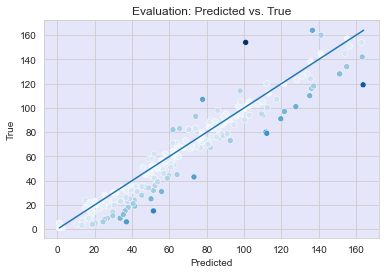

In [49]:
hue = np.abs(y_pred - y_test)

fig, ax = plt.subplots()
_ = sns.scatterplot(x=y_pred, y=y_test, 
                hue=hue, legend=False, 
                palette=colormap, ax=ax)
_ = sns.lineplot(x=[y_test.min(), y_test.max()], 
             y=[y_test.min(), y_test.max()], 
             ax = ax)
_ = ax.set_xlabel('Predicted')
_ = ax.set_ylabel('True')
ax.set_facecolor('lavender')
_ = plt.title('Evaluation: Predicted vs. True',fontsize=12, y=1.0)